# Table of Content

- [Data Loading](#Data-Loading)
- [Models Used](#Build-the-model)
    - [3D-CNN with residual connection](#3D-CNN-with-residual-connection)
    - [Transfer Learning Model](#Transfer-Learning-Model-with-ResNet)
    - [3D-CNN from Paper](#3D-CNN-from-Paper)
- [Training](#Training-the-model)
- [Visualization](#Visualization)
    - [Visualizing data images](#Visualizing-data-images)
    - [Visualizing the CNN filters](#Visualizing-CNN-filters)
    - [Attention map with CAM](#GradCAM-(class-activation-mapping))

# Data Loading

In [1]:
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import os
import numpy as np

# defining customized Dataset class for Udacity

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class UdacityDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, select_camera=None, slice_frames=None, select_ratio=1.0, select_range=None):
        
        assert select_ratio >= -1.0 and select_ratio <= 1.0 # positive: select to ratio from beginning, negative: select to ration counting from the end
        
        camera_csv = pd.read_csv(csv_file)
        if select_camera:
            assert select_camera in ['left_camera', 'right_camera', 'center_camera'], "Invalid camera: {}".format(select_camera)
            camera_csv = camera_csv[camera_csv['frame_id']==select_camera]
        
        csv_len = len(camera_csv)
        if slice_frames:
            csv_selected = camera_csv[0:0] # empty dataframe
            for start_idx in range(0, csv_len, slice_frames):
                if select_ratio > 0:
                    end_idx = int(start_idx + slice_frames * select_ratio)
                else:
                    start_idx, end_idx = int(start_idx + slice_frames * (1 + select_ratio)), start_idx + slice_frames

                if end_idx > csv_len:
                    end_idx = csv_len
                if start_idx > csv_len:
                    start_idx = csv_len
                csv_selected = csv_selected.append(camera_csv[start_idx:end_idx])
            self.camera_csv = csv_selected
        elif select_range:
            csv_selected = camera_csv.iloc[select_range[0]: select_range[1]]
            self.camera_csv = csv_selected
        else:
            self.camera_csv = camera_csv
            
        self.root_dir = root_dir
        self.transform = transform
        
        # Keep track of mean and cov value in each channel
        self.mean = {}
        self.std = {}
        for key in ['angle', 'torque', 'speed']:
            self.mean[key] = np.mean(camera_csv[key])
            self.std[key] = np.std(camera_csv[key])
    
    def __len__(self):
        return len(self.camera_csv)
    
    def read_data_single(self, idx):
        path = os.path.join(self.root_dir, self.camera_csv['filename'].iloc[idx])
        image = io.imread(path)
        timestamp = self.camera_csv['timestamp'].iloc[idx]
        frame_id = self.camera_csv['frame_id'].iloc[idx]
        angle = self.camera_csv['angle'].iloc[idx]
        torque = self.camera_csv['torque'].iloc[idx]
        speed = self.camera_csv['speed'].iloc[idx]
        
        if self.transform:
            image_transformed = self.transform(image)
            del image
            image = image_transformed
        angle_t = torch.tensor(angle)
        torque_t = torch.tensor(torque)
        speed_t = torch.tensor(speed)
        del angle, torque, speed
            
        return image, timestamp, frame_id, angle_t, torque_t, speed_t
    
    def read_data(self, idx):
        if isinstance(idx, list):
            data = None
            for i in idx:
                new_data = self.read_data(i)
                if data is None:
                    data = [[] for _ in range(len(new_data))]
                for i, d in enumerate(new_data):
                    data[i].append(new_data[i])
                del new_data
                
            for stack_idx in [0, 3, 4, 5]: # we don't stack timestamp and frame_id since those are string data
                data[stack_idx] = torch.stack(data[stack_idx])
            
            return data
        
        else:
            return self.read_data_single(idx)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.read_data(idx)
        
        sample = {'image': data[0],
                  'timestamp': data[1],
                  'frame_id': data[2],
                  'angle': data[3],
                  'torque': data[4],
                  'speed': data[5]}
        
        del data
        
        return sample

In [2]:
# generate Batch with consecutive frames taken from input data

from torch.utils.data import Sampler
import random

class ConsecutiveBatchSampler(Sampler):
    
    def __init__(self, data_source, batch_size, seq_len, drop_last=False, shuffle=True, use_all_frames=False):
        r""" Sampler to generate consecutive Batches
        
        Args:
            data_source: Source of data
            batch_size: Size of batch
            seq_len: Number of frames in each sequence (used for context for prediction)
            drop: Wether to drop the last incomplete batch
            shuffle: Wether to shuffle the data
        Return:
            List of iterators, size: [batch_size x seq_len x n_channels x height x width]
        """
        super(ConsecutiveBatchSampler, self).__init__(data_source)
        
        self.data_source = data_source
        
        assert seq_len >= 1, "Invalid batch size: {}".format(seq_len)
        self.seq_len = seq_len
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.use_all_frames_ = use_all_frames
    
    def __iter__(self):
        
        data_size = len(self.data_source)
        
        if self.use_all_frames_:
            start_indices = list(range(data_size))
        else:
            start_indices = list(range(1, data_size, self.seq_len))
            
        if self.shuffle:
            random.shuffle(start_indices)
        
        batch = []
        for idx, ind in enumerate(start_indices):
            if data_size - idx < self.batch_size and self.drop_last: # if last batch
                break
                
            seq = []
            if ind + 1 < self.seq_len:
                seq.extend([0]*(self.seq_len - ind - 1) + list(range(0, ind+1)))
            else:
                seq.extend(list(range(ind-self.seq_len+1, ind+1)))
            
            batch.append(seq)
            
            if len(batch) == self.batch_size or idx == data_size - 1:
                yield batch
                batch = []

    
    def __len__(self):
        length = len(self.data_source)
        batch_size = self.batch_size
        
        if length % batch_size == 0 or self.drop_last:
            return length // batch_size
        
        return length // batch_size + 1

# Build the model

## 3D CNN with residual connection

In [4]:
# Build the model

import torch.nn as nn

# helper function to determine dimension after convolution
def conv_output_shape(in_dimension, kernel_size, stride):
    output_dim = []
    for (in_dim, kern_size, strd) in zip(in_dimension, kernel_size, stride):
        len = int(float(in_dim - kern_size) / strd + 1.)
        output_dim.append(len)
    
    return output_dim

        
class TemporalCNN(nn.Module):
    
    def _conv_unit(self, in_channels, out_channels, in_shape, kernel_size, stride, dropout_prob):
        r""" Return one 3D convolution unit
        
        Args:
            in_channels: Input channels of the Conv3D module
            out_channels: Output channels of the Conv3D module
            in_shape: Shape of the input image. i.e. The last 3 dimensions of the input tensor: D x H x W
            kernel_size: Kernel size
            stride: Stride
            dropout_prob: Probability of dropout layer
                         
        Output:
            (conv_module, aux_module, out_shape)
        """
        
        conv = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        dropout = nn.Dropout3d(p=dropout_prob)
        conv_module = nn.Sequential(conv, dropout).to(self.device_)
        out_shape = conv_output_shape(in_shape, kernel_size, stride)
        
        flatten = nn.Flatten(start_dim=2)
        aux = nn.Linear(in_features=np.prod(out_shape[-2:])*out_channels, out_features=128)
        aux_module = nn.Sequential(flatten, aux).to(self.device_)
        
        return conv_module, aux_module, out_shape
    
    def _linear_unit(self, in_features, out_features, dropout_prob):
        linear = nn.Linear(in_features, out_features)
        relu = nn.ReLU()
        dropout = nn.Dropout(p=dropout_prob)
        return nn.Sequential(linear, relu, dropout).to(self.device_), out_features
        
    
    def __init__(self, in_height, in_width, seq_len, dropout_prob=0.5, aux_history=10, device=None):
        r""" TemporalCNN: this model does 3D convolution on the H, W and temporal dimension
             It also includes residual connection from each Conv3D output to the final output
             
             Args:
                 in_height: image height
                 in_width: image width
                 seq_len: image sequence length
                 dropout_prob: prob for the dropout layer
                 aux_history: length of history to extract from seq_len
             
             Output:
                 nn.Module, accepts input with shape [batch_len, seq_len, C, in_height, in_width]
        """
        super(TemporalCNN, self).__init__()
        
        self.seq_len_ = seq_len
        self.in_width_ = in_width
        self.in_height_ = in_height
        self.aux_history_ = aux_history
        in_shape = (seq_len, in_height, in_width)
        
        self.device_ = device if device is not None else torch.device("cpu")
        
        # conv1
        self.conv0_, self.aux0_, out_shape = self._conv_unit(3, 64, in_shape, (3, 12, 12), (1, 6, 6), dropout_prob)
        # conv2
        self.conv1_, self.aux1_, out_shape = self._conv_unit(64, 64, out_shape, (2, 5, 5), (1, 2, 2), dropout_prob)
        # conv3
        self.conv2_, self.aux2_, out_shape = self._conv_unit(64, 64, out_shape, (2, 5, 5), (1, 1, 1), dropout_prob)
        # conv4
        self.conv3_, self.aux3_, out_shape = self._conv_unit(64, 64, out_shape, (2, 5, 5), (1, 1, 1), dropout_prob)
        
        # Flatten the last 3 dims
        self.flatten_ = nn.Flatten(start_dim=2).to(self.device_)
        
        # FC 1024
        self.linear0_, out_features = self._linear_unit(64*np.prod(out_shape[-2:]), 1024, dropout_prob)
        # FC 512
        self.linear1_, out_features = self._linear_unit(out_features, 512, dropout_prob)
        # FC 256
        self.linear2_, out_features = self._linear_unit(out_features, 256, dropout_prob)
        # FC 128
        self.linear3_ = nn.Linear(out_features, 128).to(device)
        
        self.elu_ = nn.ELU().to(self.device_)
        
    def forward(self, x):
        x = x.permute([0, 2, 1, 3, 4]) # swap channel and seq_len, 3D conv over seq_len as depth channel
                                       # now: [batch_size, channel, seq_len, H, W]
        
        x = self.conv0_(x) # every conv includes dropout
        x_permute = x.permute([0, 2, 1, 3, 4])[:,-self.aux_history_:,:,:,:]
        x_aux0 = self.aux0_(x_permute)
        x = self.conv1_(x)
        x_permute = x.permute([0, 2, 1, 3, 4])[:,-self.aux_history_:,:,:,:]
        x_aux1 = self.aux1_(x_permute)
        x = self.conv2_(x)
        x_permute = x.permute([0, 2, 1, 3, 4])[:,-self.aux_history_:,:,:,:]
        x_aux2 = self.aux2_(x_permute)
        x = self.conv3_(x)
        x = x.permute([0, 2, 1, 3, 4])
        x_permute = x[:,-self.aux_history_:,:,:,:]
        x_aux3 = self.aux3_(x_permute)

        x = self.flatten_(x)
        x = self.linear0_(x)
        x = self.linear1_(x)
        x = self.linear2_(x)
        x = self.linear3_(x)
        
        final_out = x + x_aux0 + x_aux1 + x_aux2 + x_aux3
        final_out = self.elu_(final_out)
        
        return final_out


## Autoregressive LSTM

In [5]:
# Autoregressive LSTM Module

class AutoregressiveLSTMCell(nn.Module):
    
    def __init__(self, target_size, visual_feature_size, hidden_size, device=None):
        r""" AutoregressiveModule takes visual feature from 3D CNN module, pass it
             first into an internal LSTM cell and then into a Linear network. The final
             output of this module is of dimension output_size.
             
             Args:
                 target_dim: dimsion of target value. for this application 3 (angle, speed, torque)
                 visual_feature_dim:
                 output_size: output size after the Linear network
                 autoregressive_mode: wether this module work as autoregressive mode or
                     just pass the ground truth to output
             Output:
                 nn.Module
        """
        super().__init__()
        
        self.target_size_ = target_size
        self.visual_feature_size_ = visual_feature_size
        self.hidden_size_ = hidden_size
        
        self.device_ = device if device is not None else torch.device("cpu")
        
        self.lstm_cell_ = nn.LSTMCell(input_size=target_size+visual_feature_size, hidden_size=hidden_size).to(self.device_)
        self.linear_ = nn.Linear(in_features=hidden_size+visual_feature_size+target_size, out_features=target_size).to(self.device_)
    
    def forward(self, visual_features, prev_target, prev_states):
        r"""
            Output:
                (output, target_ground_truth) for autoregressive_mode = True
                (output, (output, ))
        """
        lstm_input = torch.cat((visual_features, prev_target), dim=-1)
        h_t, c_t = self.lstm_cell_(lstm_input, prev_states)
        linear_input = torch.cat((visual_features, prev_target, h_t), dim=-1)
        output = self.linear_(linear_input)
        new_state = (h_t, c_t)
        
        return output, new_state
        
class AutoregressiveLSTM(AutoregressiveLSTMCell):
    
    def __init__(self, target_size, visual_feature_size, hidden_size, autoregressive_mode=True, device=None):
        super().__init__(target_size, visual_feature_size, hidden_size, device)
        self.autoregressive_mode_ = autoregressive_mode
    
    def forward(self, visual_features, init_target=None, init_states=None, target_groundtruth=None):
        # different from LSTM in torch library, we use the second dimension for sequence!
        assert self.autoregressive_mode_ or target_groundtruth is not None
        
        seq_len = visual_features.shape[1]
        batch_len = visual_features.shape[0]

        prev_target = torch.zeros(batch_len, self.target_size_, device=self.device_) if init_target is None else init_target
        prev_states = (torch.zeros(batch_len, self.hidden_size_, device=self.device_), 
                       torch.zeros(batch_len, self.hidden_size_, device=self.device_)) if init_states is None else init_states
        
        outputs = []
        states = []
        for seq_idx in range(seq_len):
            target, state = super().forward(visual_features[:, seq_idx, :], prev_target, prev_states)
            prev_target = target if self.autoregressive_mode_ else target_groundtruth[:, seq_idx, :]
            outputs.append(target)
            states.append(torch.stack(state))
            
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2)  # dim: [batch, seq, target_size]
        states = torch.stack(states)
        states = states.permute(1, 2, 0, 3) # dim: [ [batch, seq, internal_size], [batch, seq, internal_size] ]
        
        return outputs, states
    
        

## Put them together

In [6]:
class SteerNet(nn.Module):
    
    def __init__(self, device=None, dropout_prob=0.25):
        super(SteerNet, self).__init__()
        
        self.device_ = device if device is not None else torch.device("cpu")
        
        self.model_cnn_ = TemporalCNN(in_height=480, in_width=640, seq_len=15, dropout_prob=dropout_prob, aux_history=10, device=device)
        self.feature_dropout_ = nn.Dropout(p=dropout_prob)
        self.model_lstm_gt_ = AutoregressiveLSTM(target_size=3, visual_feature_size=128, hidden_size=32, autoregressive_mode=False, device=device)
        self.model_lstm_autoreg_ = AutoregressiveLSTM(target_size=3, visual_feature_size=128, hidden_size=32, autoregressive_mode=True, device=device)
        self.lstm_state_ = None
        
        self.train_ = True
    
    def forward(self, images, target=None):
        assert target is None or self.train_==True
        
        features = self.model_cnn_(images)
        features = self.feature_dropout_(features)
        
        if self.lstm_state_ is None:
            if self.train_:
                out_gt, state_gt = self.model_lstm_gt_(features, target_groundtruth=target)
            out_autoreg, state_autoreg = self.model_lstm_autoreg_(features)
        else:
            state_autoreg = self.lstm_state_
            state_gt = (state_autoreg[0].clone().detach(),
                        state_autoreg[1].clone().detach()) # copies the state. we don't opzimize the state of this LSTM with groundtruth input!
            if self.train_:
                out_gt, _ = self.model_lstm_gt_(features, init_states=state_gt, target_groundtruth=target)
            out_autoreg, state_autoreg = self.model_lstm_autoreg_(features, init_states=state_autoreg)
        if self.train_:
            self.lstm_state_ = (state_autoreg[0][-1].detach(), state_autoreg[1][-1].detach())
        
        return (out_autoreg, out_gt) if self.train_ else out_autoreg
    
    def train(self, mode=True):
        self.train_ = mode

## Transfer Learning Model with ResNet

In [214]:
# Model definition and model loading

import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class TLearning(nn.Module):
    def __init__(self):
        super(TLearning,self).__init__()
        self.ResNet = models.resnet50(pretrained=True, progress=True)
        
        self.fc1 = nn.Linear(in_features =1000, out_features = 512, bias=True)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256, bias=True)
        self.fc3 = nn.Linear(in_features = 256, out_features = 64, bias=True)
        self.fc4 = nn.Linear(in_features = 64, out_features = 1, bias=True)
    def forward(self, Input):
        image = self.ResNet(Input)
        # input size = (1,3,224,224)-(Batches, Channels, Height, Width)
        # output size = (1, 1000)-(Batches, Feature)
        image = F.relu(self.fc1(image))
        # input size = (1,1000)-(batches, features)
        # output size = (1,512)-(batches, features)
        image = F.relu(self.fc2(image))
        # input size = (1,512)-(batches, features)
        # output size = (1,256)-(batches, features)
        image = F.relu(self.fc3(image))
        # input size = (1,256)-(batches, features)
        # output size = (1,64)-(batches, features)
        image = self.fc4(image)
        # input size = (1,64)-(batches, features
        # output size = (1,1)-(batches, features)
        return image

## 3D CNN from Paper

# Training the Model

In [43]:
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler

# Load the data

# Use the whole training dataset to calculate target mean and stddev
udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                              root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                              transform=transforms.Compose([transforms.ToTensor()]),
                              select_camera='center_camera')
print("size of training set: {}\nstat:\nmean: {}\nstd: {}".format(len(udacity_dataset), udacity_dataset.mean, udacity_dataset.std))

print(torch.mean(udacity_dataset[900]['image'][0, :, :]), torch.std(udacity_dataset[900]['image'][0, :, :]))

# Train / valid split with slices
training_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                              root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                              transform=transforms.Compose([transforms.ToTensor()]),
                              select_camera='center_camera',
                              slice_frames=100,
                              select_ratio=0.8)
validation_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                transform=transforms.Compose([transforms.ToTensor()]),
                                select_camera='center_camera',
                                slice_frames=100,
                                select_ratio=-0.2)
batch_size = 10

cbs_train = ConsecutiveBatchSampler(data_source=training_set, batch_size=batch_size, shuffle=False, drop_last=True, seq_len=15, use_all_frames=False)
cbs_valid = ConsecutiveBatchSampler(data_source=validation_set, batch_size=batch_size, shuffle=False, drop_last=True, seq_len=15, use_all_frames=False)

training_loader = DataLoader(training_set, sampler=cbs_train, collate_fn=(lambda x: x[0]))
validation_loader = DataLoader(validation_set, sampler=cbs_valid, collate_fn=(lambda x: x[0]))

size of training set: 33808
stat:
mean: {'angle': -0.008478613582381778, 'torque': -0.09063468015274655, 'speed': 15.625127605181328}
std: {'angle': 0.27152468334113167, 'torque': 0.7874424330514188, 'speed': 5.697122502690882}
tensor(0.1801) tensor(0.2422)


In [8]:
import datetime
import subprocess
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

writer = SummaryWriter('/export/jupyterlab/chengxin/runs/steernet-{}'.format(datetime.datetime.now()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} for training".format(device))

steernet = SteerNet(device=device, dropout_prob=0.25)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(steernet.parameters())

def normalize_data(sample, channel, origin_dataset):
    result = (sample[channel] - origin_dataset.mean[channel]) / origin_dataset.std[channel]
    return result

def do_epoch(epoch_num=0):
    
    # training
    steernet.train()
    
    running_cost = 0.0
    total_iterations = 0
    for i, sample in enumerate(tqdm(training_loader, total=len(training_set)/batch_size/15)):
        
        angle = sample['angle'][:, -10:]
        torque = sample['torque'][:, -10:]
        speed = sample['speed'][:, -10:]
        images = sample['image'].to(device)
        angle_normalized = normalize_data(sample, 'angle', udacity_dataset)[:, -10:]
        torque_normalized = normalize_data(sample, 'torque', udacity_dataset)[:, -10:]
        speed_normalized = normalize_data(sample, 'speed', udacity_dataset)[:, -10:]
        
        target_normalized = torch.stack([angle_normalized, torque_normalized, speed_normalized])
        target_normalized = target_normalized.permute([2, 1, 0]).to(device) # (batch_size x seq_len x target_dim)
        angle = angle.to(device)
        
        optimizer.zero_grad()
        
        out_autoreg, out_gt = steernet(images, target_normalized)
        out_autoreg_angle = out_autoreg[:, :, 0] * udacity_dataset.std['angle'] + udacity_dataset.mean['angle']
        
        loss_angle = criterion(angle, out_autoreg_angle)
        loss_autoreg = criterion(out_autoreg, target_normalized)
        loss_gt = criterion(out_gt, target_normalized)
        
        loss_total = loss_angle + do_epoch.loss_target_weight * (loss_autoreg + loss_gt)
        running_cost += loss_angle.item()
        total_iterations = i+1
        loss_total.backward()
        
        torch.nn.utils.clip_grad_norm_(steernet.model_lstm_gt_.parameters(), 15.0) # gradient clamping
        torch.nn.utils.clip_grad_norm_(steernet.model_lstm_autoreg_.parameters(), 15.0) # gradient clamping
        
        writer.add_scalar('train - loss total epoch {}'.format(epoch_num), loss_total.item(), i)
        writer.add_scalar('train - loss angle epoch {}'.format(epoch_num), loss_angle.item(), i)
        writer.add_scalar('train - loss autoreg epoch {}'.format(epoch_num), loss_autoreg.item(), i)
        writer.add_scalar('train - loss gt epoch {}'.format(epoch_num), loss_gt.item(), i)
        
        optimizer.step()
    
    running_cost = running_cost / total_iterations
    writer.add_scalar('train - angle (RMSE)', np.sqrt(running_cost), epoch_num)
    print("Finished training epoch {}".format(epoch_num))
    
    git_label = subprocess.check_output(["git", "rev-parse", "--short=6", "HEAD"]).strip().decode('UTF-8') # get current git label
    torch.save(steernet.state_dict(), "/export/jupyterlab/chengxin/models/git-{}-epoch-{}".format(git_label, epoch_num))
    
    # validation
    
    with torch.no_grad(): # we don't require grad calcualation in the validation phase. it saves memory.
        steernet.eval()

        running_cost = 0.0
        total_iterations = 0
        for i, sample in enumerate(tqdm(validation_loader, total=len(validation_set)/batch_size/15)):
            angle = sample['angle'][:, -10:]
            torque = sample['torque'][:, -10:]
            speed = sample['speed'][:, -10:]
            images = sample['image'].to(device)
            angle_normalized = normalize_data(sample, 'angle', udacity_dataset)[:, -10:]
            torque_normalized = normalize_data(sample, 'torque', udacity_dataset)[:, -10:]
            speed_normalized = normalize_data(sample, 'speed', udacity_dataset)[:, -10:]
            
            target_normalized = torch.stack([angle_normalized, torque_normalized, speed_normalized])
            target_normalized = target_normalized.permute([2, 1, 0]).to(device) # (batch_size x seq_len x target_dim)
            angle = angle.to(device)

            out_autoreg = steernet(images)
            out_autoreg_angle = out_autoreg[:, :, 0] * udacity_dataset.std['angle'] + udacity_dataset.mean['angle']

            loss_angle = criterion(angle, out_autoreg_angle)
            loss_autoreg = criterion(out_autoreg, target_normalized)
            
            writer.add_scalar('valid - loss angle epoch {}'.format(epoch_num), loss_angle.item(), i)
            writer.add_scalar('valid - loss autoreg epoch {}'.format(epoch_num), loss_autoreg.item(), i)
            running_cost += loss_angle.item()
            total_iterations = i+1
        
        running_cost = running_cost / total_iterations
        writer.add_scalar('valid - angle (RMSE)', np.sqrt(running_cost), epoch_num)
                  
    print("Finished validating epoch {}".format(epoch_num))
    
do_epoch.loss_target_weight = 0.1

Using cuda for training


In [15]:
for epoch in range(1):
    do_epoch(epoch)


Finished training epoch 0



Finished validating epoch 0


# Visualization

## Visualizing CNN filters

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_cnn(cnn, max_row=10, max_col=10, select_channel=None, tb_writer=None):
    assert isinstance(cnn, nn.Conv3d) or isinstance(cnn, nn.Conv2d)
    
    filters = cnn.weight.cpu().detach().numpy() # output_ch x input_ch x D x H x W
    output_ch = np.minimum(cnn.weight.shape[0], max_col)
    input_ch = np.minimum(cnn.weight.shape[1], max_row)
    print(filters.shape)
    
    if isinstance(cnn, nn.Conv3d):
        if select_channel:
            assert isinstance(select_channel, int)
            filters = filters[:, :, select_channel, :, :]
        else:
            filters = np.mean(filters[:, :, :, :, :], axis=2)
    
    plt_idx = 0
    fig = plt.figure(figsize=(output_ch, input_ch))
    for o in range(output_ch):
        for i in range(input_ch):
            image = filters[o, i, :, :]
            plt_idx += 1
            ax = fig.add_subplot(input_ch, output_ch, plt_idx)
            ax.imshow(image)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

(64, 64, 2, 5, 5)


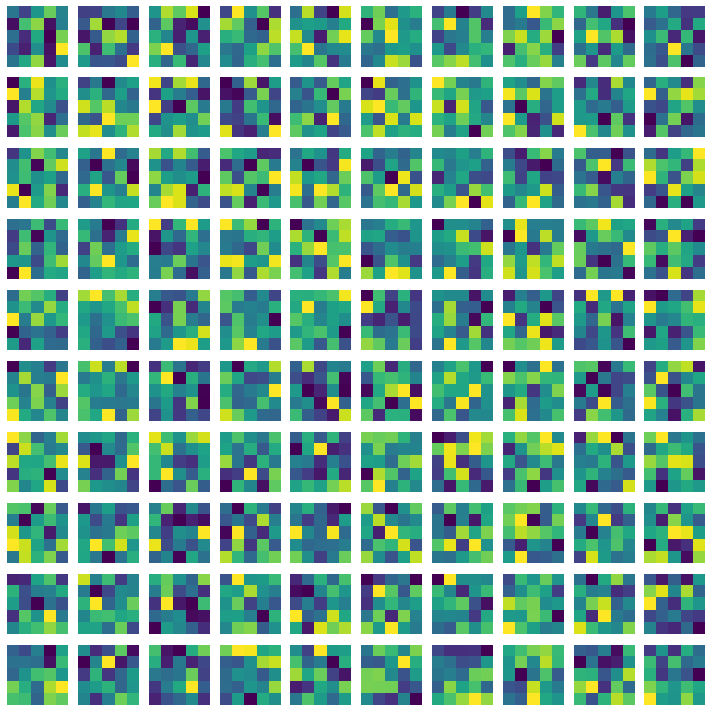

In [21]:
visualize_cnn(steernet.model_cnn_.conv3_[0], select_channel=0)

(64, 3, 7, 7)


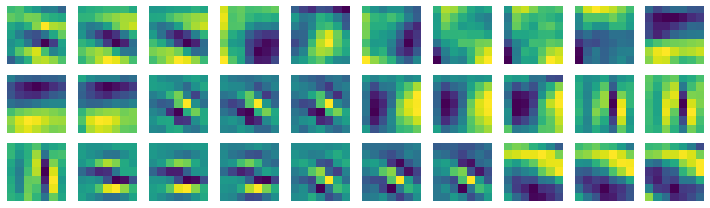

In [143]:
visualize_cnn(tl_model.ResNet.conv1)

In [34]:
def show_sample(sample):
    r""" Helper function for (batch) sample visualization
    
    Args:
        sample: Dictionary
    """
    image_dims = len(sample['image'].shape)
    assert image_dims <= 5, "Unsupported image shape: {}".format(sample['image'].shape)
    if image_dims == 3:
        plt.imshow(sample['image'].permute(1,2,0))
    else:
        n0 = sample['image'].shape[0]
        n1 = sample['image'].shape[1] if image_dims == 5 else 1
        images_flattened = torch.flatten(sample['image'], end_dim=-4)
        fig, ax = plt.subplots(n0, n1, figsize=(25, 15))
        for i1 in range(n1):
            for i0 in range(n0):
                image = images_flattened[i0 * n1 + i1]
                axis = ax[i0, i1]
                axis.imshow(image.permute(1,2,0))
                axis.axis('off')
                axis.set_title("t={}".format(sample['timestamp'][i0][i1]))
                axis.text(10, 30, sample['frame_id'][i0][i1], color='red')
            
    

## GradCAM (class activation mapping)

In [113]:
from skimage.transform import resize

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, register_hooks=True):
        self.model = model
        self.grad = None
        self.conv_output = None
        
        if register_hooks:
            self.register_hooks()
        
    def gradient_hook(self, model, grad_input, grad_output):
        self.grad = grad_output[0].cpu().detach().numpy()
        
    def conv_output_hook(self, model, input, output):
        self.conv_output = output.cpu().detach().numpy()
        
    def register_hooks(self):
        raise NotImplementedError("You should implement this method for your own model!")
        
    def forward(self, x):
        raise NotImplementedError("You should implement this method for your own model!")
        
    def to_image(self, height=None, width=None):
        assert self.grad is not None and self.conv_output is not None, "You should perform both forward pass and backward propagation first!"
        # both grad and conv_output should have the same dimension of: (*, channel, H, W)
        # we produce image(s) of shape: (*, H, W)
        channel_weight = np.mean(self.grad, axis=(-2, -1)) # *, channel
        conv_permuted = np.moveaxis(self.conv_output, [-2, -1], [0, 1]) # H, W, *, channel
        cam_image_permuted = channel_weight * conv_permuted # H, W, *, channel
        cam_image_permuted = np.mean(cam_image_permuted, axis=-1) # H, W, *
        cam_image = np.moveaxis(cam_image_permuted, [0, 1], [-2, -1]) # *, H, W
        
        if height is not None and width is not None:
            image_shape = list(cam_image.shape)
            image_shape[-2] = height
            image_shape[-1] = width
            cam_image = resize(cam_image, image_shape)
        return cam_image
        
    
class CamExtractorTLModel(CamExtractor):
    
    def register_hooks(self):
        self.model.ResNet.layer4.register_forward_hook(self.conv_output_hook)
        self.model.ResNet.layer4.register_backward_hook(self.gradient_hook)

class CamExtractor3DCNN(CamExtractor):
    
    def gradient_hook(self, model, grad_input, grad_output):
        grad = grad_output[0].cpu().detach().numpy()
        self.grad = np.moveaxis(grad, 1, 2) # restore old dimension (batch x seq_len x channel x H x W)
        
    def conv_output_hook(self, model, input, output):
        conv_output = output.cpu().detach().numpy()
        self.conv_output = np.moveaxis(conv_output, 1, 2) # restore old dimension (batch x seq_len x channel x H x W)
    
    def register_hooks(self):
        self.model.Convolution6.register_forward_hook(self.conv_output_hook)
        self.model.Convolution6.register_backward_hook(self.gradient_hook)
    

In [30]:
sample = udacity_dataset[3693]
show_sample(sample)
print(sample['angle'])

test_image = sample['image'].reshape(-1, 3, 480, 640).cuda()
tl_model = TLearning()
tl_model.load_state_dict(torch.load('thirdparty/transfer_learning_lintao/Angle_Adam_MSE_Paper_Model/Angle_Adam_MSE_Paper_Model-epoch-4'))
tl_model.cuda()

tl_extractor = CamExtractorTLModel(tl_model)
#print("grad, conv_output = ", tl_extractor.grad_input, tl_extractor.grad_output, tl_extractor.forward_input, tl_extractor.forward_output)

#model_output = tl_extractor.forward(test_image)
model_output = tl_model(test_image)

print(tl_extractor.conv_output.shape)

tl_model.zero_grad()
mse_loss = nn.MSELoss()
loss = mse_loss(model_output, sample['angle'].cuda().reshape(1,1))
loss.backward()
# grad_output = torch.zeros(1, 1)
# grad_output[0][0] = sample['angle']

print(len(tl_extractor.grad))
print(tl_extractor.grad[0].shape)

# fig = plt.figure()
# plt.imshow(np.mean(tl_extractor.grad[0].detach().numpy(), axis=(0,1)))
# fig = plt.figure()
# plt.imshow(np.mean(tl_extractor.conv_output, axis=(0,1)))

cam_image = tl_extractor.to_image(height=480, width=640)
print(cam_image.shape)
#plt.figure()
plt.imshow(cam_image[0, :, :], cmap='jet', alpha=0.5)
plt.savefig('test.png')

NameError: name 'show_sample' is not defined

In [32]:
# attention overlay for 3D CNN model

from thirdparty.FangLintao.Model import CNN_3D_Paper

cnn_model = CNN_3D_Paper.Convolution3D()
cnn_model.load_state_dict(torch.load("/export/jupyterlab/chengxin/thirdparty/FangLintao/3DCNN_Model-epoch-5"))
cnn_model.cuda()


Convolution3D(
  (Convolution1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (BatchN1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaxPooling1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0), dilation=1, ceil_mode=False)
  (MaxPooling2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0), dilation=1, ceil_mode=False)
  (Convolution2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (BatchN2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ResConvolution1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (averagePool1): AvgPool3d(kernel_size=1, stride=1, padding=(0, 0, 0))
  (ResBatchN1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Convolution3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (BatchN3): BatchNorm3d(

In [114]:
device = torch.device("cuda")
cnn_cam_extractor = CamExtractor3DCNN(cnn_model)

Batch_size = 5
Seq_len = 5 

udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')

testing_cbs = ConsecutiveBatchSampler(data_source=udacity_dataset, batch_size=Batch_size, shuffle=False, drop_last=False, seq_len=Seq_len)
testing_loader = DataLoader(udacity_dataset, sampler=testing_cbs, collate_fn=(lambda x: x[0]))

torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])
torch.Size([5, 5])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


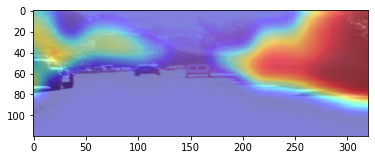

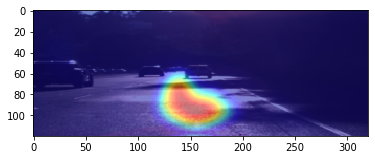

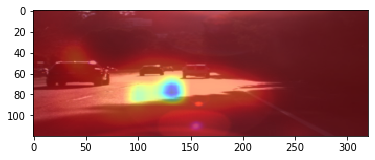

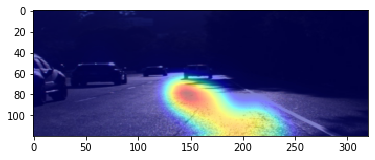

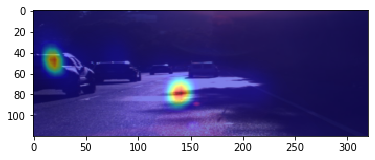

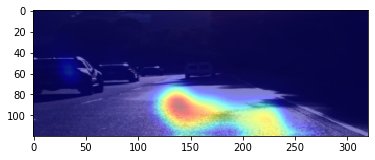

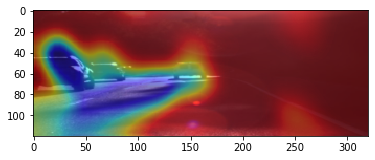

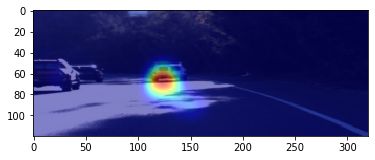

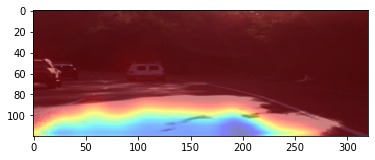

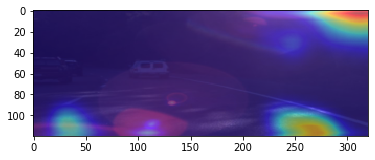

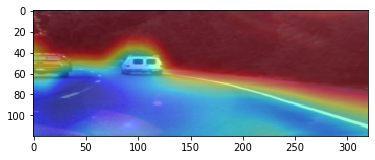

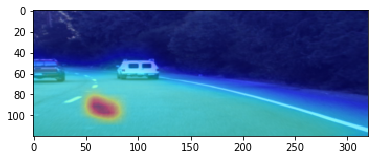

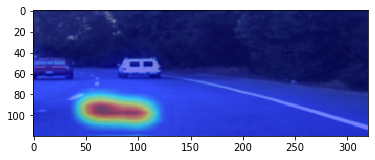

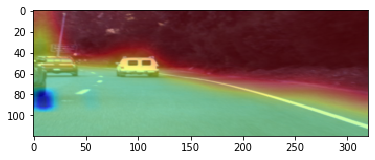

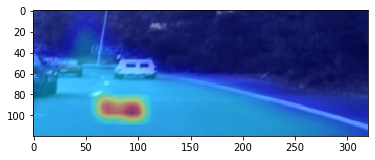

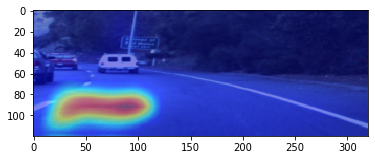

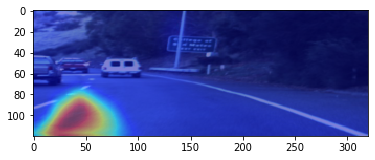

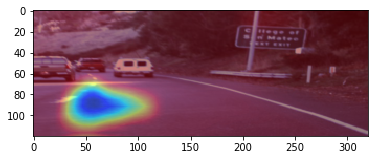

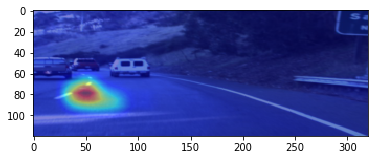

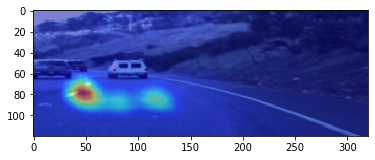

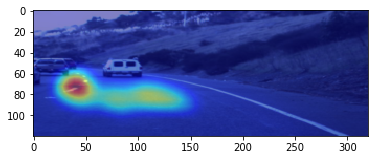

In [116]:
import torch.nn as nn

mse_loss = nn.MSELoss()

for i, testing_sample in enumerate(testing_loader):
    testing_sample['image'] = torch.Tensor(resize(testing_sample['image'], (Batch_size,Seq_len,3,120,320),anti_aliasing=True))
    testing_sample['image'] = testing_sample['image'].permute(0,2,1,3,4)
    image = testing_sample['image'].to(device)
    prediction = cnn_model(image).squeeze()
    print(prediction.shape)
    target = testing_sample['angle'].to(device)
    loss = mse_loss(prediction, target)
    loss.backward()
    
    plt.figure()
    cam_image = cnn_cam_extractor.to_image(width=320, height=120)
    plt.imshow(testing_sample['image'][0, :, -1, :, :].permute(1, 2, 0))
    plt.imshow(cam_image[0, -1, :, :], cmap='jet', alpha=0.5)
    
    if i==20:
        break

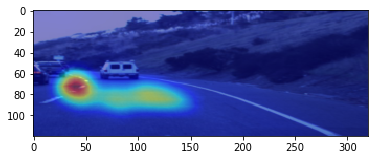

In [129]:
plt.imshow(testing_sample['image'][4, :, -1, :, :].permute(1, 2, 0))
plt.imshow(cam_image[0, -1, :, :], cmap='jet', alpha=0.5)